# Building, Deploying and Serving a Sticker Sales Forecasting Machine Learning Model with fastai and Modal

### Background

In January 2025, Kaggle ran a playground series [competition](https://www.kaggle.com/competitions/playground-series-s5e1/overview) to forecast multiple years' worth of sticker sales in different countries. For each id row, you have to predict the `num_sold` which represents the number of stickers sold for each product type per store in each country.

This notebook walks through building, deploying and serving a machine learning model for forecasting sticker sales. 

I do my tabular data preprocessing and build my model using [fastai](https://docs.fast.ai/), I then push my training, test and validation data to modal and run a script which runs the training job on modal cloud. 

Now we can proceed to run some python scripts which deploy and serve the same model to a web endpoint in modal as we shall see below. 
I can then pass new data without a sales column to this API and expect it to return the same data with new sales predictions in a new num_sold column.

[Modal](https://modal.com/) is a serveless cloud platform that enables us to run and execute any python code in the cloud without having to manage infrastructure. Modal makes it easy to attach GPU'S with just one line of code and can serve our functions as web endpoints.

Modal makes deploying ML models simple with:

- Containerized environments defined in code
- Seamless scaling
- GPU support (when needed)
- Easy endpoint creation

I previously showed how to train, serve and deploy a machine learning model to a live API endpoint with bentoml and bentocloud [here](https://nbsanity.com/static/ac40bb062434c7446906d3eb8875e061/load.html). 

The solution we are building below will allow us to:

- Train a gradient boosting model to predict sticker sales
- Use Modal for serverless deployment
- Create an API endpoint for predictions
- Visualize results with a Streamlit dashboard. 

After we are done deploying and serving our machine learning model, we build a UI where we pass in the API link. This can be used to make calls to the API from our streamlit dashboard. 

[Streamlit]((https://streamlit.io/)) is an open source framework that we can use to quickly build web applications.

Once we are done building our web application, we can pass in our data for a single prediction using a form etc.

We can also do batch prediction by passing in a csv file of the new data you want it will make predictions on. 

Our batch prediction solution looks like below when we are done.

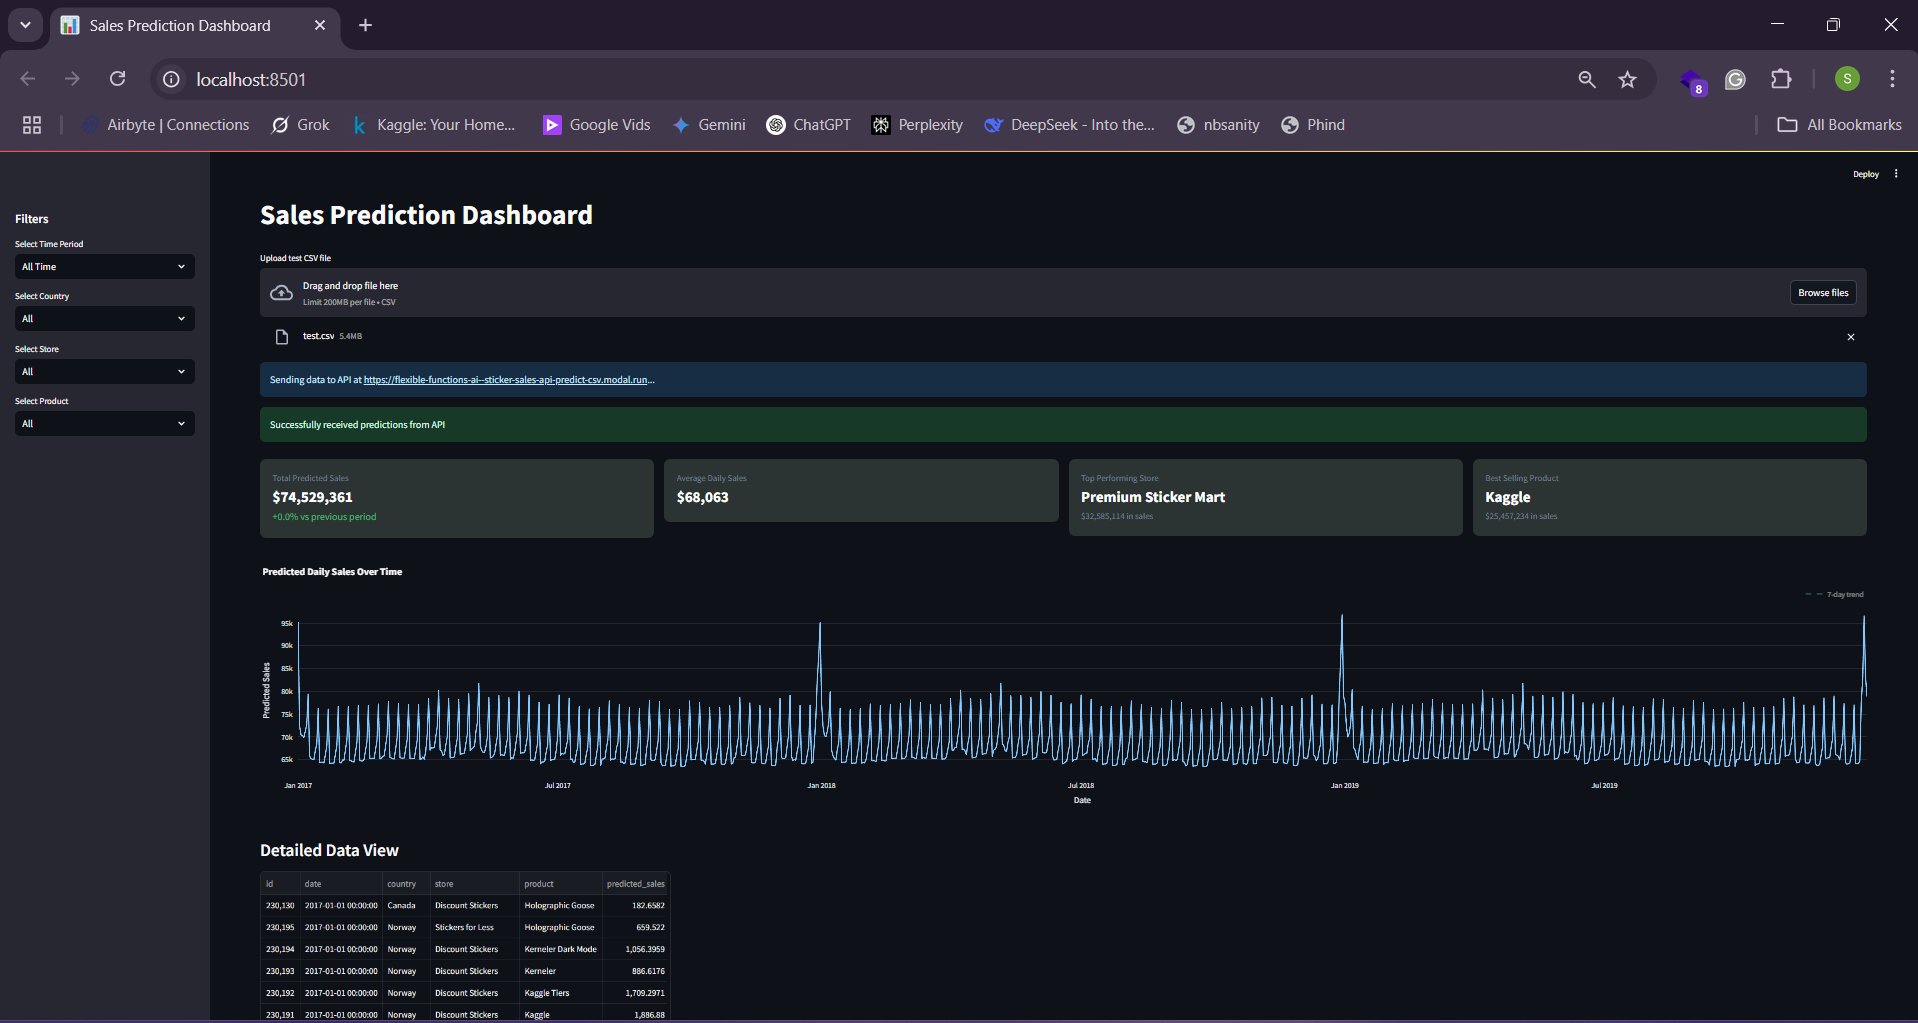

As you can see above, once we pass in previously unseen data, our model returns new predictions for the number of stickers to be sold.

### Evaluation

The competition submissions were evaluated on the [Mean Absolute Percentage Error (MAPE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) metric which expresses the average absolute error as a percentage of the actual values, making it easy to understand the relative size of errors.

For example, if you predict a value of 90 when the actual is 100, the percentage error is 10%, but if you predict 110 when the actual is 100, the percentage error is also 10%. MAPE averages these absolute percentage errors across all observations.

> NB: The data for this competition was synthentically generated but was made to contain real world patterns and effects that you might see in real world data such as seasonality, weekend and holiday effect, etc.

Let's get started!

### Project Structure

We start by creating our project file structure which should follow the structure below. Follow this and create the neccesary directories and files. 

The training data, `train.csv` shall automatically be loaded into the data folder as we shall see in the Extract and Load section below hence we just need to create the `data` folder.

```
sticker_sales_model_deployment/
├── data/
    └── train.csv                  # Training and test data
    └── test.csv                   # Test data
    └── sample_submission.csv      # sample submission data for kaggle
    └── transformed_data.csv       # Training data extracted from airbyte data - Approach 2
    └── local_filename.csv         # airbyte data from s3 - ELT job
    └── output.csv                 # Training data extracted from airbyte data - Approach 1
├── data_upload.py                 # Upload data to modal cloud
├── train.py                       # Modal model training
├── serve.py                       # Create API service with Modal
├── test_modal_api.py              # Modal API test
└── ui/
    └── streamlit_ui.py            # Streamlit dashboard
```

### Setting Up Your Environment

Let's start by setting up our environment. We start by logging into modal by running ```modal setup``` via our terminal. 

We then install the libraries we need for this project by running the below pip installations via your terminal.

You can do the same installation by running `pip install catboost seaborn xgboost lightgbm fastkaggle -Uqq fastbook polars tqdm gradio dash streamlit plotly requests boto3 modal bentoml pandas` via your terminal in your home directory which in this case would be `sticker_sales_model_deployment/`.

In [1]:
#| code-fold: true
#| output: false
#| code-summary: "Library Installation"


%pip install catboost
#%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
%pip install polars
%pip install tqdm
#%pip install wandb
#%pip install sweetviz
#%pip install --upgrade scipy
%pip install gradio
%pip install dash
%pip install streamlit plotly requests
%pip install boto3
%pip install modal bentoml 
%pip install streamlit pandas requests plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

### Imports

In [ ]:
#| code-fold: true
#| output: false
#| code-summary: "Library Import"

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
#from fastkaggle import setup_comp
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.linear_model import LinearRegression

#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor,Pool, metrics, cv


import warnings


matplotlib.rc('image', cmap='Greys')
import scipy.stats as stats



#import h2o
#from h2o.automl import H2OAutoML

import gc
#import wandb

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

import dash
from dash import dcc, html, dash_table

import boto3
import io
import getpass
import json

from joblib import dump, load
import typing as t
import bentoml
from bentoml.validators import DataframeSchema

import modal

## Extract and Load with Airbyte

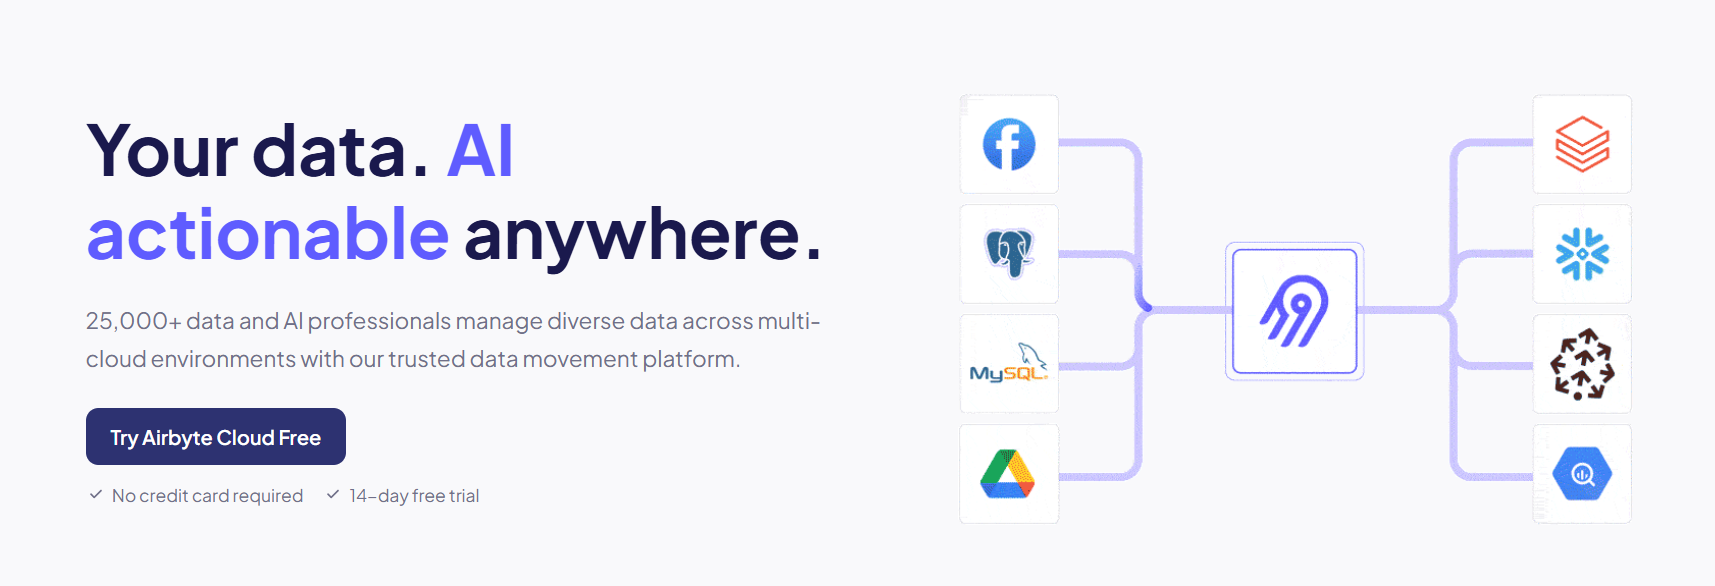

To replicate/mirror how we would build & work with systems in real life, where data sources might be in different data sources such as ERP systems, spreadsheet software, social media apps, websites, etc.

I use [Airbyte](https://airbyte.com/), an open source tool that can be used to extract and load data from one source to another to build data pipelines. 

This shows how one would go about extracting data from different sources to a single data warehouse / lake. With this we can always easily pull our neccesary data into our native training enviroment.

To demonstrate this in our example, we uploaded our training csv data into a google sheet and then pulled it [AWS S3](https://aws.amazon.com/pm/serv-s3/?trk=6b57822f-2fb8-4067-ab88-bac5e4381331&sc_channel=ps&ef_id=CjwKCAjwiezABhBZEiwAEbTPGMl3dan1CR4wYsinMeyynJXXo1n2ucMlT0VrRjc6t15aU9FN3BDqIhoCjJ8QAvD_BwE:G:s&s_kwcid=AL!4422!3!645125274608!p!!g!!aws%20s3%20web%20hosting!19574556923!145779858632&gad_campaignid=19574556923&gbraid=0AAAAADjHtp843MDwcEXA-az1hu6WnKFcn&gclid=CjwKCAjwiezABhBZEiwAEbTPGMl3dan1CR4wYsinMeyynJXXo1n2ucMlT0VrRjc6t15aU9FN3BDqIhoCjJ8QAvD_BwE). Airbyte is well suited to handle this.

I show the whole process in this [Video showing and Extract and Load job with Airbyte](https://drive.google.com/file/d/1oHN74oTUawj-WFLNgN8h2LqxzkWkEtrD/view?usp=sharing).

Once the data has been extracted from google sheets to AWS S3, we run the code below to pull the data from AWS S3 into our notebook and native training enviroment.


In [ ]:
#| include: false
#| code-fold: true
#| output: false
#| code-summary: "AWS Authentication"

# Get AWS credentials securely through interactive input
aws_access_key = input("Enter your AWS access key: ")
aws_secret_key = getpass.getpass("Enter your AWS secret key: ")

# Create S3 client with user-provided credentials
s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)

# Now you can use s3_client as before
# For example:
# response = s3_client.get_object(Bucket='your-bucket', Key='your-file.csv')
# df = pd.read_csv(io.BytesIO(response['Body'].read()))

In [ ]:
# Method 1: Download file to local and then read
s3_client.download_file('flexible-functions', 'sticker-sales/train.csv/ss_train.csv', 'data/local_filename_ss.csv')
airbyte_df = pd.read_csv('data/local_filename_ss.csv')

Our data is in the `_airbyte_data` column, so lets go ahead and extract it. We have a few ways we can do this.

### Approach 1

In [ ]:
# Extract the JSON blobs from the '_airbyte_data' column
data = airbyte_df['_airbyte_data'].apply(json.loads)

# Convert the extracted JSON data into a DataFrame
extracted_df = pd.json_normalize(data)

# Save the extracted DataFrame to a CSV file in the data folder
extracted_df.to_csv("data/output.csv", index=False)
print("Data successfully extracted and saved to data/output.csv")

output_df = pd.read_csv('data/output.csv')
output_df.head()

### Approach 2 

We can load our data in a more optimal way. Lets do that below

In [ ]:
def transform_airbyte_data(input_file, output_file):
    """
    Transform Airbyte raw data format back to original tabular format
    
    Parameters:
    input_file (str): Path to the input file (CSV or JSON) from Airbyte
    output_file (str): Path to save the transformed CSV file
    
    Returns:
    pd.DataFrame: The transformed DataFrame
    """
    file_ext = os.path.splitext(input_file)[1].lower()
    
    # Read the data based on file type
    if file_ext == '.csv':
        df = pd.read_csv(input_file)
    elif file_ext == '.json':
        df = pd.read_json(input_file, lines=True)  # Assuming JSONL format
    else:
        raise ValueError(f"Unsupported file extension: {file_ext}. Use .csv or .json")
    
    # Check if the data is in Airbyte format
    airbyte_columns = [col for col in df.columns if col.startswith('_airbyte_')]
    
    if '_airbyte_data' in df.columns:
        # If *airbyte*data is a string column, parse it to dictionaries
        if df['_airbyte_data'].dtype == 'object' and isinstance(df['_airbyte_data'].iloc[0], str):
            df['_airbyte_data'] = df['_airbyte_data'].apply(json.loads)
        
        # Extract the data from *airbyte*data column
        extracted_data = pd.json_normalize(df['_airbyte_data'])
        
        # Convert numeric columns if needed
        for col in extracted_data.columns:
            if col in ['id', 'num_sold']:
                try:
                    extracted_data[col] = pd.to_numeric(extracted_data[col])
                except:
                    pass  # Keep as string if conversion fails
                    
        # Save the result
        extracted_data.to_csv(output_file, index=False)
        print(f"Transformed data saved to {output_file}")
        
        return extracted_data
    else:
        print("Data doesn't appear to be in Airbyte format. No transformation needed.")
        df.to_csv(output_file, index=False)
        return df

In [ ]:
# Example usage
if __name__ == "__main__":
    # Use paths in the data folder
    input_file = "data/local_filename_ss.csv"  # or .json
    output_file = "data/transformed_data.csv"
    
    transformed_df = transform_airbyte_data(input_file, output_file)
    transformed_df.head()

### Load data

We only did an ELT job for the training dataset for demonstration

For the test and sample submission file, we shall load them from the local files already available in the `data/` folder.

In [5]:
path = Path('')
path

Path('.')

In [ ]:
!ls

In [6]:
train_df = pd.read_csv(path/'data/transformed_data.csv',index_col='id')
test_df = pd.read_csv(path/'data/test.csv',index_col='id')
sub_df = pd.read_csv(path/'data/sample_submission.csv')

## Exploratory Data Analysis

In [ ]:
train_df.columns

In [ ]:
train_df.shape,test_df.shape

In [ ]:
# For a specific column (e.g., column 'A')
missing_values_count = train_df['num_sold'].isnull().sum()
missing_values_count

In [ ]:
train_df['num_sold'].isnull().mean() * 100

## Data Upload - `data_upload.py`

We are now going to start by uploading our data to modal using volumes. To quote the modal documentation

> Modal Volumes provide a high-performance distributed file system for your modal applications. They are designed for write-once, read-many I/O workloads, like creating machine learning model weights and distributing them for inference.

Uploading our data will enable our training function that we run later to access the data it will need to train our machine learning model.

NB: You can achieve the same data upload functionality using modal Images by using the `image.add_local_dir` and `image.add_local_file` image builder methods. This can be done by creating an image that has our data like below

```
sticker_data_image = (
    modal.Image.debian_slim()
    .pip_install(["pandas", "numpy", "xgboost", "bentoml"])
    # Add your local data directory to the image
    .add_local_dir("./data", remote_path="/data")
)
```
For this example, I shall be uploading my data using modal volumes as opposed to using images.

Navigate to your ```data_upload.py``` file and paste the below code which whose purpose we shall explain in detail.

In [ ]:
import modal
import sys
from pathlib import Path

# Create an app for the data upload 
app = modal.App("sticker-data-upload")


Here we are initializing a modal application named `sticker-data-upload`.

Modal is a cloud platform that lets you run Python functions in the cloud. The App class is used to define a Modal application which is just a group of functions and classes that are deployed together.

In [ ]:
# Create a volume to persist data
volume = modal.Volume.from_name("sticker-data-volume", create_if_missing=True)

We then define our volume with ```modal.Volume.from_name``` which creates a persistent storage volume in modal named ```sticker-data-volume```. The ```create_if_missing=True``` flag means it will create the volume if it doesn't already exist. 

Volumes in modal are like shared disk space that can persist between function runs.

In [ ]:
#| code-fold: show
#| code-summary: "Modal Data Upload"

@app.function(volumes={"/data": volume})
def upload_data(local_data_path):
    import shutil
    import os
    
    # Ensure the destination directory exists
    os.makedirs("/data", exist_ok=True)
    
    # Copy all files from the local data directory to the volume
    for file in Path(local_data_path).glob("*"):
        dest = f"/data/{file.name}"
        if file.is_file():
            shutil.copy(file, dest)
            print(f"Copied {file} to {dest}")
    
    # List files to confirm upload
    print("\nFiles in Modal volume:")
    for file in Path("/data").glob("*"):
        print(f" - {file}")


Remember our modal app can consist of various functions and classes. To explicitly register an object with the app, we use the ```@app.function()``` decorator.

We can now define the function, `upload_data` to upload our data. The function takes in one argument, `local_data_path` which is the path to the directory on our local machine that contains the files we would like to upload.

Inside the function, start by creating the `/data` directory if it does not exist. We then iterate through our local file directory.

For each file, we create a destination path in our modal volume, and if it is a file, copy it from our local directory to our previously defined modal volume and then it prints a confirmation message.

Finally, It prints a list of all files in the volume.

In [ ]:
@app.local_entrypoint()
def main():
    if len(sys.argv) > 1:
        data_path = sys.argv[1]
    else:
        data_path = "./data"  # Default path
    
    print(f"Uploading data from {data_path}")
    upload_data.remote(data_path)

The ```@app.local_entrypoint()``` decorator defines a Command Line entry point for our modal app and it marks a function, in this case `main` to be executed locally.

This function then parses command-line arguments such as the data path, print a local message, and then triggers the actual data uploading process.

Our function, `main` triggers our function `upload_data` to be executed remotely in the modal cloud by calling `upload_data.remote(data_path)` .

To upload the data, run ```python modal_upload.py ./data``` via the terminal to trigger the data upload.

## Model Training - `train.py`

Next, we'll create a script to train our forecasting model. Navigate to your ```train.py``` file and paste the code in the below model training section whose code i shall explain. 

In [ ]:
#import modal
#import pandas as pd
#import numpy as np
#from fastai.tabular.all import *  # Move this import to the top level
#import xgboost as xgb
#import bentoml
#from pathlib import Path
#import os
#import pickle

# Define Modal resources
app = modal.App("sticker-sales-forecast")

Above, we define a modal app called ```sticker-sales-forecast```.

In [ ]:
image = modal.Image.debian_slim().pip_install([
    "fastai", 
    "xgboost", 
    "bentoml", 
    "scikit-learn", 
    "pandas", 
    "numpy", 
    "torch"
])

We then define an image which is a snapshot of our container's filesystem state. 

We can easily add any third-party packages like ```torch```, ```pandas``` by passing in all the packages we need to the ```pip_install``` method of an image as shown above.

In [ ]:
volume = modal.Volume.from_name("sticker-data-volume")


After defining our dependencies, we call and attach an existing volume called ```sticker-data-volume``` which we previously defined when doing our data upload.

This contains the data needed for our model training in the ```train_model``` function defined below.

We define our ```@app.function``` decorator passing in our specified image and volume mounted at "/data".

In [ ]:
#| code-fold: show
#| code-summary: "Forecasting Model Training Function" 

# Define paths for pickle-based model saving
MODEL_PATH = "/data/sticker_sales_model.pkl"
PREPROC_PATH = "/data/sticker_sales_preproc.pkl"

@app.function(image=image, volumes={"/data": volume})
def train_model():
    # No need to import fastai.tabular.all here since we moved it to the top
    
    # Set up paths
    path = Path('/data/')
    
    # Check if data files exist
    print("Files available in volume:")
    for file in path.glob("*"):
        print(f" - {file}")
    
    # Load data
    print("Loading data...")
    train_df = pd.read_csv(path/'train.csv', index_col='id')
    test_df = pd.read_csv(path/'test.csv', index_col='id')
    
    # Data preprocessing
    print("Preprocessing data...")
    train_df = train_df.dropna(subset=['num_sold'])
    train_df = add_datepart(train_df, 'date', drop=False)
    test_df = add_datepart(test_df, 'date', drop=False)
    
    # Feature preparation
    cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
    splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
    to = TabularPandas(train_df, procs=[Categorify, FillMissing, Normalize],
                      cat_names=cat_names,
                      cont_names=cont_names,
                      y_names='num_sold',
                      y_block=CategoryBlock(),
                      splits=splits)
    dls = to.dataloaders(bs=64)
    
    # Prepare training data
    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
    
    # Train XGBoost model
    print("Training XGBoost model...")
    xgb_model = xgb.XGBRegressor()
    xgb_model = xgb_model.fit(X_train, y_train)
    
    # Save model with BentoML
    print("Saving model with BentoML...")
    model_tag = bentoml.xgboost.save_model(
        "sticker_sales_v1", 
        xgb_model,
        custom_objects={
            "preprocessor": {
                "cont_names": cont_names,
                "cat_names": cat_names
            }
        }
    )
    
    # Save model with pickle
    print(f"Saving model with pickle to {MODEL_PATH}...")
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump(xgb_model, f)
    
    # Save preprocessing info separately
    print(f"Saving preprocessing info to {PREPROC_PATH}...")
    preproc_info = {
        "cont_names": cont_names,
        "cat_names": cat_names,
        "procs": [Categorify, FillMissing, Normalize]
    }
    with open(PREPROC_PATH, 'wb') as f:
        pickle.dump(preproc_info, f)
    
    # Ensure changes are committed to the volume
    volume.commit()
    
    print(f"Model saved: {model_tag} and to pickle files")
    return str(model_tag)

In our code above, I am defining a function `train_model`. 

In this function, I start by setting up the paths and loading the training and test data into their respective data frames, ```train_df``` and ```test_df```.

I then do some basic preprocessing steps on our data frames.

First, from our exploratory data analysis above, I noticed that our target column, `num_sold` has missing values which would intefere with our model training, so first we handle this. 

We can deal with these missing values with several techniques like filling in with the mean, median, or a random value. From testing, I noticed the best strategy for this is to drop all the rows with missing values by running `train_df = train_df.dropna(subset=['num_sold'])`.

We then use the [```add_datepart```](https://docs.fast.ai/tabular.core.html#add_datepart) helper function from [fast.ai](https://docs.fast.ai/) to add columns/features relevant to the date column in a data frame if available. This is defined using ``` add_datepart (df, field_name, prefix=None, drop=True, time=False)```. 

For example, if we have a date column with a row that has `2019-12-04`. We can derive new columns from that date such as `Year`, `Month`, `Day`, `Dayofweek`, `Is_month_start`, `Is_quarter_end`, etc.

Our machine learning model expects our training data to be in a certain format. Luckily, fastai has functions which we shall see below that can help transform this raw data into a format that can be efficiently and effectively processed by a neural network.

We then go on to define categorical and continuous variables, I use the fastai [`cont_cat_split`](https://docs.fast.ai/tabular.core.html#cont_cat_split) function to separate my dataset variables into categorical and continuous variables based of the cardinality of my column values.

`cont_cat_split` takes an argument `max card` whose default is 20. If the number of unique values exceeds 20 (max_card value) for a particular column, that column is considered continuous, and vice versa.

I then use [`RandomSplitter`](https://docs.fast.ai/data.transforms.html#randomsplitter), a fastai function that splits our training data into new training and validation sets. 

It separates the training dataset into training and validation sets based on the value of the `argument valid_pct`.

We can now use fastai's `TabularPandas` class to create a `TabularPandas` object that applies given preprocessing steps to our data. 

This creates a data frame wrapper that takes in different arguments and knows which columns are categorical and continuous. I also define the target variable, `y_name`, the type of target, the problem we are dealing with such as a regression problem in this case, and the way to split our data which was previously defined in the ```splits``` above.

I define a list of preprocessing steps, `Procs`, to be taken on our data which we pass to our `TabularPandas` object. `Procs` contains the below preprocessing steps.

+ `Categorify` deals with the categorical variables and converts each category into a list of indexable numerical integers, creating numerical input which is required by our model. Each category corresponds to a different number.

+ `FillMissing` as its name suggests, fills in the missing values in columns with continuous values. This can be filled in with the median, mode of that column, or a constant, with the default being the median value for that particular column. 

FillMissing supports using the mode and a constant as strategies for dealing with missing values. We can do this by changing the FillMissing argument `fill_strategy` to mode or constant.

+ `Normalize` puts the continuous variables between a standardized scale without losing important information by subtracting the mean and dividing by the standard deviation.

We can now define a `DataLoader` which is an extension of PyTorch's `DataLoaders` class albeit with more functionality. This takes in our data above from the `TabularPandas` object and prepares it as input for our model passing it in batches which we defined by our batch size set by the `bs` argument.

The `DataLoaders` and `TabularPandas` objects allow us to build data objects we can use for training without specifically changing the raw input data.

The `dataloader` then acts as input for our models.

- To use other libraries with fastai, I extract the x's and y's from my `TabularPandas` object which I used to preprocess the data.
I can now directly use the training and validation set values I extracted above as direct input for decision trees and gradient-boosting models.

An instance of XGBRegressor is then created with default parameters, and a model is trained by calling `.fit()` with the training features (`X_train`) and target values (`y_train`). The model is finally serialized and saved to the bentoML model store. 

### Entry Point

In [ ]:
@app.local_entrypoint()
def main():
    # Train the model remotely
    print("Starting model training on Modal...")
    model_tag = train_model.remote()
    print(f"Model training completed. Model tag: {model_tag}")
    print(f"Model and preprocessing info also saved as pickle files at {MODEL_PATH} and {PREPROC_PATH}")

Above, we define our entry point. 

As explained before the ```@app.local_entrypoint()``` decorator, declared above makes this function the entry point when you run the script locally and it triggers the remote execution of the `train_model` function in modal cloud by calling ```train_model.remote()``` within our `main` function.

```
@app.local_entrypoint()
def main():
    # Train the model remotely
    print("Starting model training on Modal...")
    model_tag = train_model.remote()
    print(f"Model training completed. Model tag: {model_tag}")
```

Now run ```python modal_train.py``` via the terminal to trigger the machine learning model training and saving in modal cloud.

## Trained model serving and deployment -  `serve.py`

After training our model, we can proceed to deploy and serve our trained machine learning model.

To do this, go to the ```serve.py``` file and paste all the code in the below model serving and deployment section.

Just like before, we create a modal app called `sticker-sales-api` which acts as the container for all the functions that will be deployed.

In [ ]:
#import modal
#import pandas as pd
#import numpy as np
#from fastapi import File, UploadFile, Form, HTTPException
#import io

# Create app definition
app = modal.App("sticker-sales-api")

# Define base image with all dependencies
base_image = (modal.Image.debian_slim()
         .pip_install("pydantic==1.10.8")        
         .pip_install("fastapi==0.95.2")         
         .pip_install("uvicorn==0.22.0")         
         .pip_install("bentoml==1.3.2")          
         .pip_install([                         
             "xgboost==1.7.6",
             "scikit-learn==1.3.1",
             "pandas",
             "numpy",
         ]))

# Create the fastai image by extending the base image
fastai_image = (base_image
                .pip_install(["fastai", "torch"]))

We then go ahead and define two separate container images.

The main image, ```base_image``` includes dependencies for the API (FastAPI, pydantic, uvicorn) plus modal-related packages (BentoML, XGBoost, scikit-learn).

A separate ```fastai_image``` is created to avoid dependency conflicts, as fastai has specific requirements for torch and other packages.

In [ ]:
# Create volume to access data
data_volume = modal.Volume.from_name("sticker-data-volume")

Just like before, we call and attach an exisiting volume called ```sticker-data-volume```.

In [ ]:
# Simple health endpoint
@app.function(image=base_image)
@modal.fastapi_endpoint(method="GET")
def health():
    """Health check endpoint to verify the API is running"""
    return {"status": "healthy", "service": "sticker-sales-api"}

We define a health endpoint to provide a simple way to check if our API service is alive and functioning correctly. We can use this to verify our service is available without needing to test the full prediction functionality.

In [ ]:
#| code-fold: show
#| code-summary: "Forecasting Model Serving Function" 

# Function to train and save model - this is a direct function without any BentoML
@app.function(image=fastai_image, volumes={"/data": data_volume})
def train_xgboost_model():
    """Train an XGBoost model and return it directly"""
    import xgboost as xgb
    from fastai.tabular.all import add_datepart, TabularPandas, cont_cat_split
    from fastai.tabular.all import Categorify, FillMissing, Normalize, CategoryBlock, RandomSplitter, range_of
    from pathlib import Path
    import pickle
    import os
    
    # Create a path to save the model for future use
    model_path = "/data/sticker_sales_model.pkl"
    
    # Check if model already exists
    if os.path.exists(model_path):
        print(f"Loading existing model from {model_path}")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        return model
    
    try:
        print("Training new model...")
        # Load and preprocess training data
        path = Path('/data/')
        
        print("Loading training data...")
        train_df = pd.read_csv(path/'train.csv', index_col='id')
        
        # Drop rows with missing target values
        train_df = train_df.dropna(subset=['num_sold'])
        
        # Add date features
        print("Preprocessing data...")
        train_df = add_datepart(train_df, 'date', drop=False)
        
        # Feature preparation
        cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
        splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
        
        # Create TabularPandas processor
        to = TabularPandas(train_df, 
                          procs=[Categorify, FillMissing, Normalize],
                          cat_names=cat_names,
                          cont_names=cont_names,
                          y_names='num_sold',
                          y_block=CategoryBlock(),
                          splits=splits)
        
        # Prepare training data
        X_train, y_train = to.train.xs, to.train.ys.values.ravel()
        
        # Train a simple XGBoost model
        print("Training XGBoost model...")
        xgb_model = xgb.XGBRegressor(n_estimators=100)
        xgb_model.fit(X_train, y_train)
        
        # Save model to file
        print(f"Saving model to {model_path}")
        with open(model_path, 'wb') as f:
            pickle.dump(xgb_model, f)
        
        print("Model training complete!")
        return xgb_model
        
    except Exception as e:
        import traceback
        print(f"Error training model: {str(e)}")
        print(traceback.format_exc())
        raise

Above we define a function ```train_xgboost_model``` not to be confused with our previous t`train_mdeol` function that we defined in our `train.py` script.

First, it checks if a trained model exists in our current model_path in our modal volume. 

If found, it loads the existing model; if not, it trains a new one. This is a fallback mechanism built into the serving API that first checks if a model exists at a specific path on the volume.

This ensures the API endpoint can always return predictions, even if the scheduled training hasn't run yet.

We then define a ```predict_csv``` function which creates a REST API endpoint that enables batch predictions for multiple sticker sales records via a CSV file upload.

Our function 

- Accepts CSV Uploads: It's a POST endpoint that accepts a CSV file upload containing multiple sticker records (with date, country, store, product features)

- Ensures Model Availability: It calls the train_xgboost_model.remote() function which either loads an existing model from the Modal volume if available or trains a new model if one doesn't exist yet


- Handles Preprocessing: It properly processes the uploaded CSV data:

It parses the uploaded CSV, Adds date-related features with add_datepart, Applies the same preprocessing transformations (Categorify, FillMissing, Normalize) that were used during training and finally creates a test dataloader with the proper format expected by the model


- Makes Predictions: It runs the model on the prepared data

- Returns Results: It returns the sales predictions as a JSON array that can be consumed by clients

This function essentially creates a convenient batch prediction service, allowing your Streamlit dashboard (or any client) to upload a CSV file and immediately get back predictions without having to handle the preprocessing or model loading logic themselves.
The Streamlit dashboard then uses these predictions to create visualizations, calculate KPIs, and enable interactive filtering of the results.

In [ ]:

# CSV upload endpoint 
@app.function(image=fastai_image, volumes={"/data": data_volume})
@modal.fastapi_endpoint(method="POST")
async def predict_csv(file: UploadFile = File(...)):
    """API endpoint for batch predictions from a CSV file"""
    import xgboost as xgb
    import io
    import pickle
    from fastai.tabular.all import add_datepart, TabularPandas, cont_cat_split
    from fastai.tabular.all import Categorify, FillMissing, Normalize, CategoryBlock, RandomSplitter, range_of
    from pathlib import Path
    
    try:
        # First, train or load model
        model = train_xgboost_model.remote()
        
        # Read uploaded CSV file content
        contents = await file.read()
        
        # Parse CSV data
        try:
            test_df = pd.read_csv(io.BytesIO(contents))
        except Exception as e:
            return {
                "success": False,
                "error": f"Failed to parse uploaded CSV: {str(e)}"
            }
        
        # Load the training data for preprocessing
        path = Path('/data/')
        train_df = pd.read_csv(path/'train.csv', index_col='id')
        train_df = train_df.dropna(subset=['num_sold'])
        
        # Add date features to both datasets
        train_df = add_datepart(train_df, 'date', drop=False)
        test_df = add_datepart(test_df, 'date', drop=False)
        
        # Feature preparation
        cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
        splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
        
        # Create TabularPandas processor
        to = TabularPandas(train_df, 
                          procs=[Categorify, FillMissing, Normalize],
                          cat_names=cat_names,
                          cont_names=cont_names,
                          y_names='num_sold',
                          y_block=CategoryBlock(),
                          splits=splits)
        
        # Create a test dataloader
        dls = to.dataloaders(bs=64)
        test_dl = dls.test_dl(test_df)
        
        # Make predictions using our model
        predictions = model.predict(test_dl.xs)
        
        # Return the predictions as a simple list
        return predictions.tolist()
            
    except Exception as e:
        import traceback
        return {
            "success": False,
            "error": f"Error processing CSV: {str(e)}",
            "traceback": traceback.format_exc()
        }

In [ ]:

@app.local_entrypoint()
def main():
    """Local entrypoint for testing the API"""
    print("Starting sticker-sales-api...")
    
    # Pre-train the model to ensure it exists
    print("Training model...")
    train_xgboost_model.remote()
    print("Model training complete!")
    
    print("\nAPI is ready for use at:")
    print("- Health check: https://flexible-functions-ai--sticker-sales-api-health.modal.run")
    print("- CSV predictions: https://flexible-functions-ai--sticker-sales-api-predict-csv.modal.run")

The `@app.local_entrypoint()` function in serve.py serves as the initialization script for the Modal deployment. This function has several important purposes:

Local Development Entry Point: This is the function that runs when you execute python serve.py on your local machine.
Pre-Training During Deployment: By calling train_xgboost_model.remote(), it ensures a model is immediately available when the API goes live by:

Either loading an existing model from the volume if it exists
Or training a new model if one doesn't exist yet

This pre-training prevents the first API call from having to wait for model training.
Endpoint Information: It prints the URLs where the deployed API endpoints can be accessed, making it easier for developers to know where to send requests.
Modal Deployment Hook: Modal requires at least one function decorated with @app.local_entrypoint() to properly deploy your application.

This pattern creates a smoother deployment experience where your model is prepared and ready before any user makes their first API call. It's particularly helpful during initial deployment and testing phases when you want immediate feedback on whether your endpoints are working correctly.

After, we are done running, deploying and serving our app on modal cloud. We can see the App and its API's in the modal dashboard.

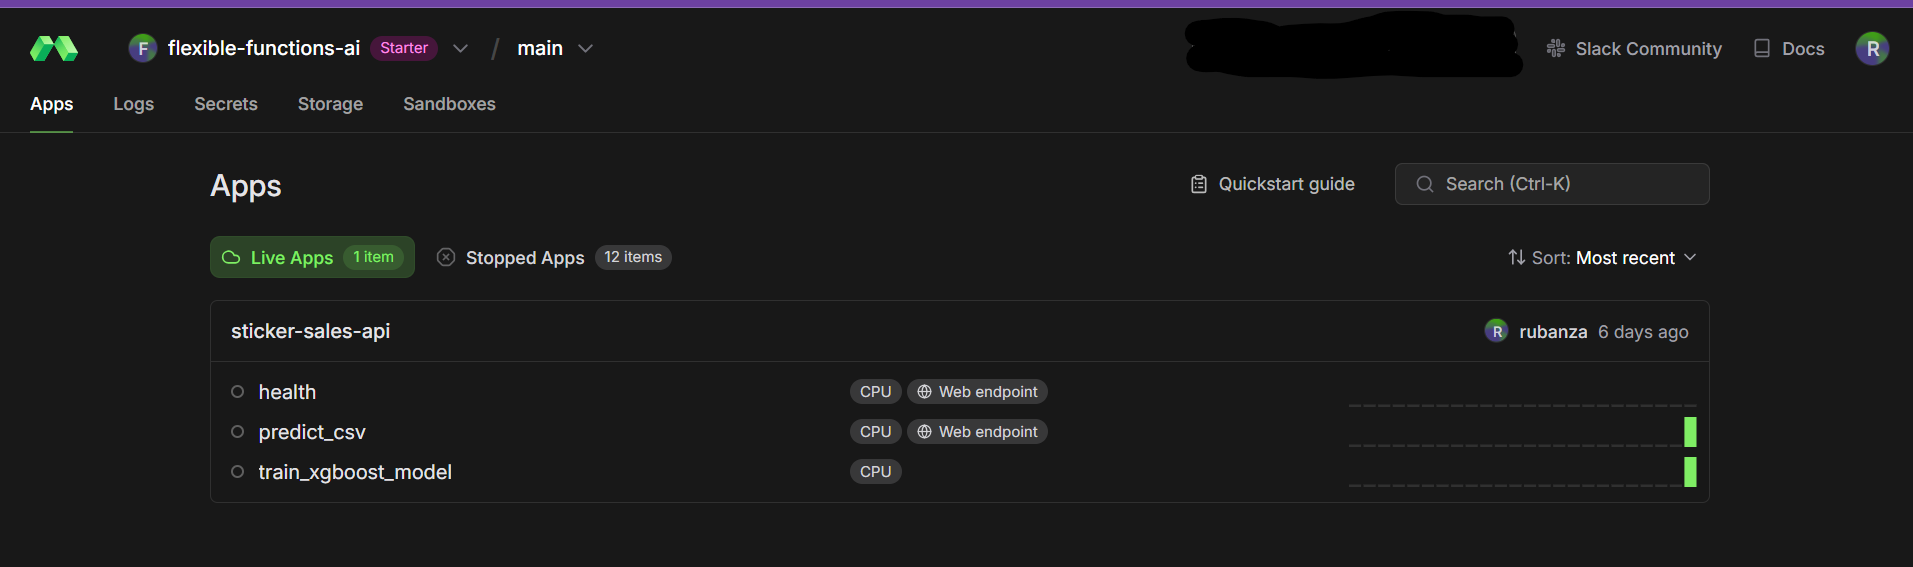

## Testing the API.

Navigate to the home directory and create a script called ```test_modal_api.py```. We shall use this to test that our api is working as expected. 

Paste the below code

In [ ]:
import requests
import pandas as pd
import io

# The URL of your CSV prediction endpoint
url = "https://flexible-functions-ai--sticker-sales-api-predict-csv.modal.run"

# Create a sample CSV with test data
test_data = pd.DataFrame([
    {
        "date": "2023-01-15",
        "country": "US",
        "store": "Store_001",
        "product": "Sticker_A"
    },
    {
        "date": "2023-01-15",
        "country": "Canada",
        "store": "Discount Stickers",
        "product": "Holographic Goose"
    },
    {
        "date": "2023-01-16",
        "country": "UK",
        "store": "Sticker World",
        "product": "Kaggle"
    }
])

# Save the test data to a CSV file in memory
csv_buffer = io.StringIO()
test_data.to_csv(csv_buffer, index=False)
csv_bytes = csv_buffer.getvalue().encode()

# Prepare the file for upload
files = {'file': ('test_data.csv', csv_bytes, 'text/csv')}

# Make the prediction request
print(f"Sending request to {url}...")
response = requests.post(url, files=files)

# Print the result
print("Status code:", response.status_code)

# Try to parse the JSON response
try:
    prediction = response.json()
    print("Prediction:", prediction)
    
    # If the prediction is a list as expected
    if isinstance(prediction, list):
        # Create a DataFrame with predictions
        result_df = test_data.copy()
        result_df['predicted_sales'] = prediction
        print("\nPrediction results:")
        print(result_df)
except Exception as e:
    print("Error parsing response:", e)
    print("Response text:", response.text[:500])

To run the api test, Run `python test_modal_api.py` via the terminal. 

This returns predictions, something like below.

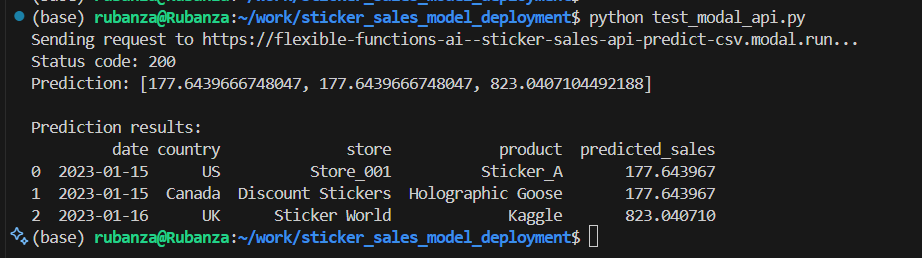

## Streamlit UI.

Finally, let's create a Streamlit dashboard to visualize our predictions. To do this, we use streamlit which as described before,

> is an open-source Python framework for data scientists and AI/ML engineers to deliver dynamic data apps with only a few lines of code.

We navigate to our home directory and create a new folder which we shall name `ui`. Under this folder we create a file and name it ```streamlit_ui.py```.

Copy and paste the below code into this file. This enables us to create an interactive dashboard using Streamlit that allows users to upload sales data, get predictions from a remote API, and visualize the results. 

In [ ]:
# Import required libraries
import streamlit as st
import pandas as pd
import requests
import json
import plotly.express as px
from datetime import datetime
import io

def load_and_predict_data(csv_path):
    """
    Sends the test CSV to the API endpoint and gets predictions
    """
    try:
        # Read the CSV file
        test_df = pd.read_csv(csv_path)
        
        # Set the API URL
        api_url = "https://flexible-functions-ai--sticker-sales-api-predict-csv.modal.run"
        
        # Prepare the file for upload using proper multipart/form-data format
        with open(csv_path, 'rb') as f:
            files = {'file': ('test_data.csv', f, 'text/csv')}
            
            # Make the request
            st.info(f"Sending data to API at {api_url}...")
            response = requests.post(api_url, files=files)
        
        # Check if the request was successful
        if response.status_code == 200:
            try:
                result = response.json()
                
                # Check if the result is an error message
                if isinstance(result, dict) and not result.get('success', True):
                    st.error(f"Error from API: {result.get('error', 'Unknown error')}")
                    st.error("Using dummy predictions for demonstration")
                    test_df['predicted_sales'] = 100  # Dummy predictions
                else:
                    # Assume the result is a list of predictions
                    if isinstance(result, list) and len(result) == len(test_df):
                        st.success("Successfully received predictions from API")
                        test_df['predicted_sales'] = result
                    else:
                        st.warning(f"Unexpected response format. Using dummy predictions.")
                        st.json(result)  # Show the actual response
                        test_df['predicted_sales'] = 100  # Dummy predictions
            except Exception as e:
                st.error(f"Error parsing API response: {str(e)}")
                st.text(f"Response text: {response.text[:500]}")  # Show first 500 chars
                test_df['predicted_sales'] = 100  # Dummy predictions
        else:
            st.error(f"API returned status code: {response.status_code}")
            st.text(f"Response text: {response.text[:500]}")  # Show first 500 chars
            test_df['predicted_sales'] = 100  # Dummy predictions
        
        # Convert date column to datetime
        test_df['date'] = pd.to_datetime(test_df['date'])
        
        return test_df
    
    except Exception as e:
        st.error(f"Error processing prediction request: {str(e)}")
        # Return a dummy dataframe for demonstration
        test_df = pd.read_csv(csv_path)
        test_df['predicted_sales'] = 100  # Dummy prediction values
        test_df['date'] = pd.to_datetime(test_df['date'])
        return test_df


Our `load_and_predict_data(csv_path)` function handles the prediction workflow where we read in a CSV file containing sales data. We then send the data to a Modal API endpoint which processes the API response to get predictions.

We add robust error handling with fallback to dummy predictions if anything fails. Finally this returns a dataframe with the original data plus the predicted sales. 

We then define pur `create_dashboard()` function which builds the Streamlit interface and

+ Sets up the page title and custom CSS styling for the metrics cards
+ Implements a file uploader for users to upload their CSV data
+ Creates sidebar filters for time period, country, store, and product
+ Calculates KPI metrics (total sales, average sales, etc.)
+ Builds four metric cards showing key performance indicators
+ Generates a time series visualization of daily sales with Plotly
+ Displays a detailed data table at the bottom

In [ ]:
def create_dashboard():
    """
    Creates the Streamlit dashboard with enhanced filters, KPI cards, and visualizations
    """
    st.title("Sales Prediction Dashboard")
    
    # Add custom CSS for dark theme cards
    st.markdown("""
        <style>
        .metric-card {
            background-color: #2C3333;
            padding: 20px;
            border-radius: 10px;
            margin: 10px 0;
        }
        .metric-label {
            color: #718096;
            font-size: 0.875rem;
        }
        .metric-value {
            color: white;
            font-size: 1.5rem;
            font-weight: bold;
        }
        .trend-positive {
            color: #48BB78;
        }
        .trend-negative {
            color: #F56565;
        }
        </style>
    """, unsafe_allow_html=True)
    
    # File uploader for the test CSV
    uploaded_file = st.file_uploader("Upload test CSV file", type=['csv'])
    
    if uploaded_file is not None:
        # Save the uploaded file temporarily
        with open('temp_test.csv', 'wb') as f:
            f.write(uploaded_file.getvalue())
        
        # Load data and get predictions
        df = load_and_predict_data('temp_test.csv')
        
        # Convert date column to datetime if not already
        df['date'] = pd.to_datetime(df['date'])
        
        # Creating filters in a sidebar
        st.sidebar.header("Filters")
        
        # Time period filter
        time_periods = {
            'All Time': None,
            'Last Month': 30,
            'Last 3 Months': 90,
            'Last Year': 365
        }
        selected_period = st.sidebar.selectbox('Select Time Period', list(time_periods.keys()))
        
        # Country filter
        countries = ['All'] + sorted(df['country'].unique().tolist())
        selected_country = st.sidebar.selectbox('Select Country', countries)
        
        # Store filter
        stores = ['All'] + sorted(df['store'].unique().tolist())
        selected_store = st.sidebar.selectbox('Select Store', stores)
        
        # Product filter
        products = ['All'] + sorted(df['product'].unique().tolist())
        selected_product = st.sidebar.selectbox('Select Product', products)
        
        # Apply filters
        filtered_df = df.copy()
        
        # Apply time filter
        if time_periods[selected_period]:
            max_date = filtered_df['date'].max()
            cutoff_date = max_date - pd.Timedelta(days=time_periods[selected_period])
            filtered_df = filtered_df[filtered_df['date'] >= cutoff_date]
        
        if selected_country != 'All':
            filtered_df = filtered_df[filtered_df['country'] == selected_country]
        if selected_store != 'All':
            filtered_df = filtered_df[filtered_df['store'] == selected_store]
        if selected_product != 'All':
            filtered_df = filtered_df[filtered_df['product'] == selected_product]
        
        # Calculate metrics for KPI cards
        total_sales = filtered_df['predicted_sales'].sum()
        avg_daily_sales = filtered_df.groupby('date')['predicted_sales'].sum().mean()
        
        # Calculate period-over-period changes
        if time_periods[selected_period]:
            previous_period = filtered_df['date'].min() - pd.Timedelta(days=time_periods[selected_period])
            previous_df = df[df['date'] >= previous_period]
            previous_df = previous_df[previous_df['date'] < filtered_df['date'].min()]
            
            prev_total_sales = previous_df['predicted_sales'].sum()
            sales_change = ((total_sales - prev_total_sales) / prev_total_sales * 100 
                          if prev_total_sales != 0 else 0)
        else:
            sales_change = 0
            
        # Create KPI cards using columns
        col1, col2, col3, col4 = st.columns(4)
        
        with col1:
            st.markdown(f"""
                <div class="metric-card">
                    <div class="metric-label">Total Predicted Sales</div>
                    <div class="metric-value">${total_sales:,.0f}</div>
                    <div class="{'trend-positive' if sales_change >= 0 else 'trend-negative'}">
                        {sales_change:+.1f}% vs previous period
                    </div>
                </div>
            """, unsafe_allow_html=True)
            
        with col2:
            st.markdown(f"""
                <div class="metric-card">
                    <div class="metric-label">Average Daily Sales</div>
                    <div class="metric-value">${avg_daily_sales:,.0f}</div>
                </div>
            """, unsafe_allow_html=True)
            
        with col3:
            top_store = (filtered_df.groupby('store')['predicted_sales']
                        .sum().sort_values(ascending=False).index[0])
            store_sales = (filtered_df.groupby('store')['predicted_sales']
                         .sum().sort_values(ascending=False).iloc[0])
            
            st.markdown(f"""
                <div class="metric-card">
                    <div class="metric-label">Top Performing Store</div>
                    <div class="metric-value">{top_store}</div>
                    <div class="metric-label">${store_sales:,.0f} in sales</div>
                </div>
            """, unsafe_allow_html=True)
            
        with col4:
            top_product = (filtered_df.groupby('product')['predicted_sales']
                          .sum().sort_values(ascending=False).index[0])
            product_sales = (filtered_df.groupby('product')['predicted_sales']
                           .sum().sort_values(ascending=False).iloc[0])
            
            st.markdown(f"""
                <div class="metric-card">
                    <div class="metric-label">Best Selling Product</div>
                    <div class="metric-value">{top_product}</div>
                    <div class="metric-label">${product_sales:,.0f} in sales</div>
                </div>
            """, unsafe_allow_html=True)
        
        # Group by date and calculate daily total predicted sales
        daily_sales = filtered_df.groupby('date')['predicted_sales'].sum().reset_index()
        
        # Create the line chart using Plotly with dark theme
        fig = px.line(
            daily_sales,
            x='date',
            y='predicted_sales',
            title='Predicted Daily Sales Over Time'
        )
        
        # Update layout for dark theme
        fig.update_layout(
            template="plotly_dark",
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
            xaxis_title="Date",
            yaxis_title="Predicted Sales",
            hovermode='x unified',
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
        
        # Add trend line
        fig.add_scatter(
            x=daily_sales['date'],
            y=daily_sales['predicted_sales'].rolling(7).mean(),
            name='7-day trend',
            line=dict(dash='dash', color='#48BB78'),
            visible='legendonly'
        )
        
        # Display the plot
        st.plotly_chart(fig, use_container_width=True)
        
        # Display detailed data view
        st.subheader("Detailed Data View")
        st.dataframe(
            filtered_df.sort_values('date'),
            hide_index=True
        )

if __name__ == "__main__":
    # Set page configuration at the very beginning
    st.set_page_config(
        page_title="Sales Prediction Dashboard",
        page_icon="📊",
        layout="wide",
        initial_sidebar_state="expanded"
    )
    create_dashboard()

Navigate to the terminal, and run `streamlit run streamlit_ui.py` to run the streamlit app. It brings up an option to upload a csv file. We upload our test set which looks like below.

In [7]:
test_df.head()

,date,country,store,product
id,,,,
230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
230131,2017-01-01,Canada,Discount Stickers,Kaggle
230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
230133,2017-01-01,Canada,Discount Stickers,Kerneler
230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


Once we upload our file, the data is sent to the batch prediction api and it returns predictions for the number of sticker sold per day for each product type in each country and for each shop as we can see below.


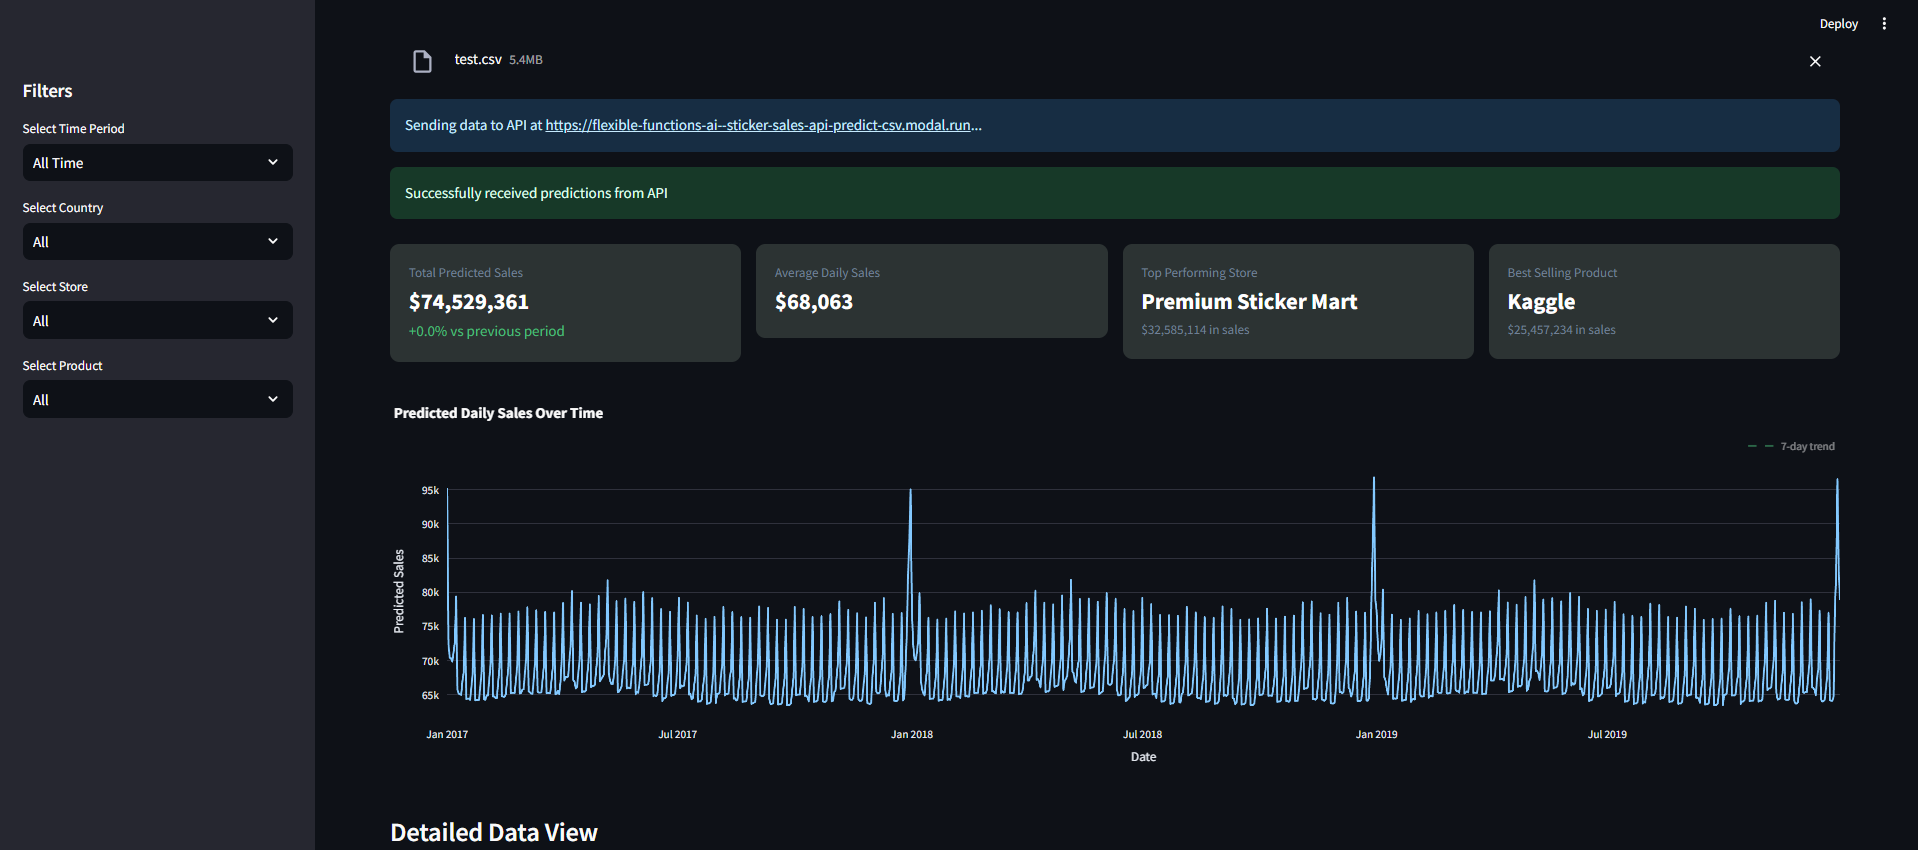

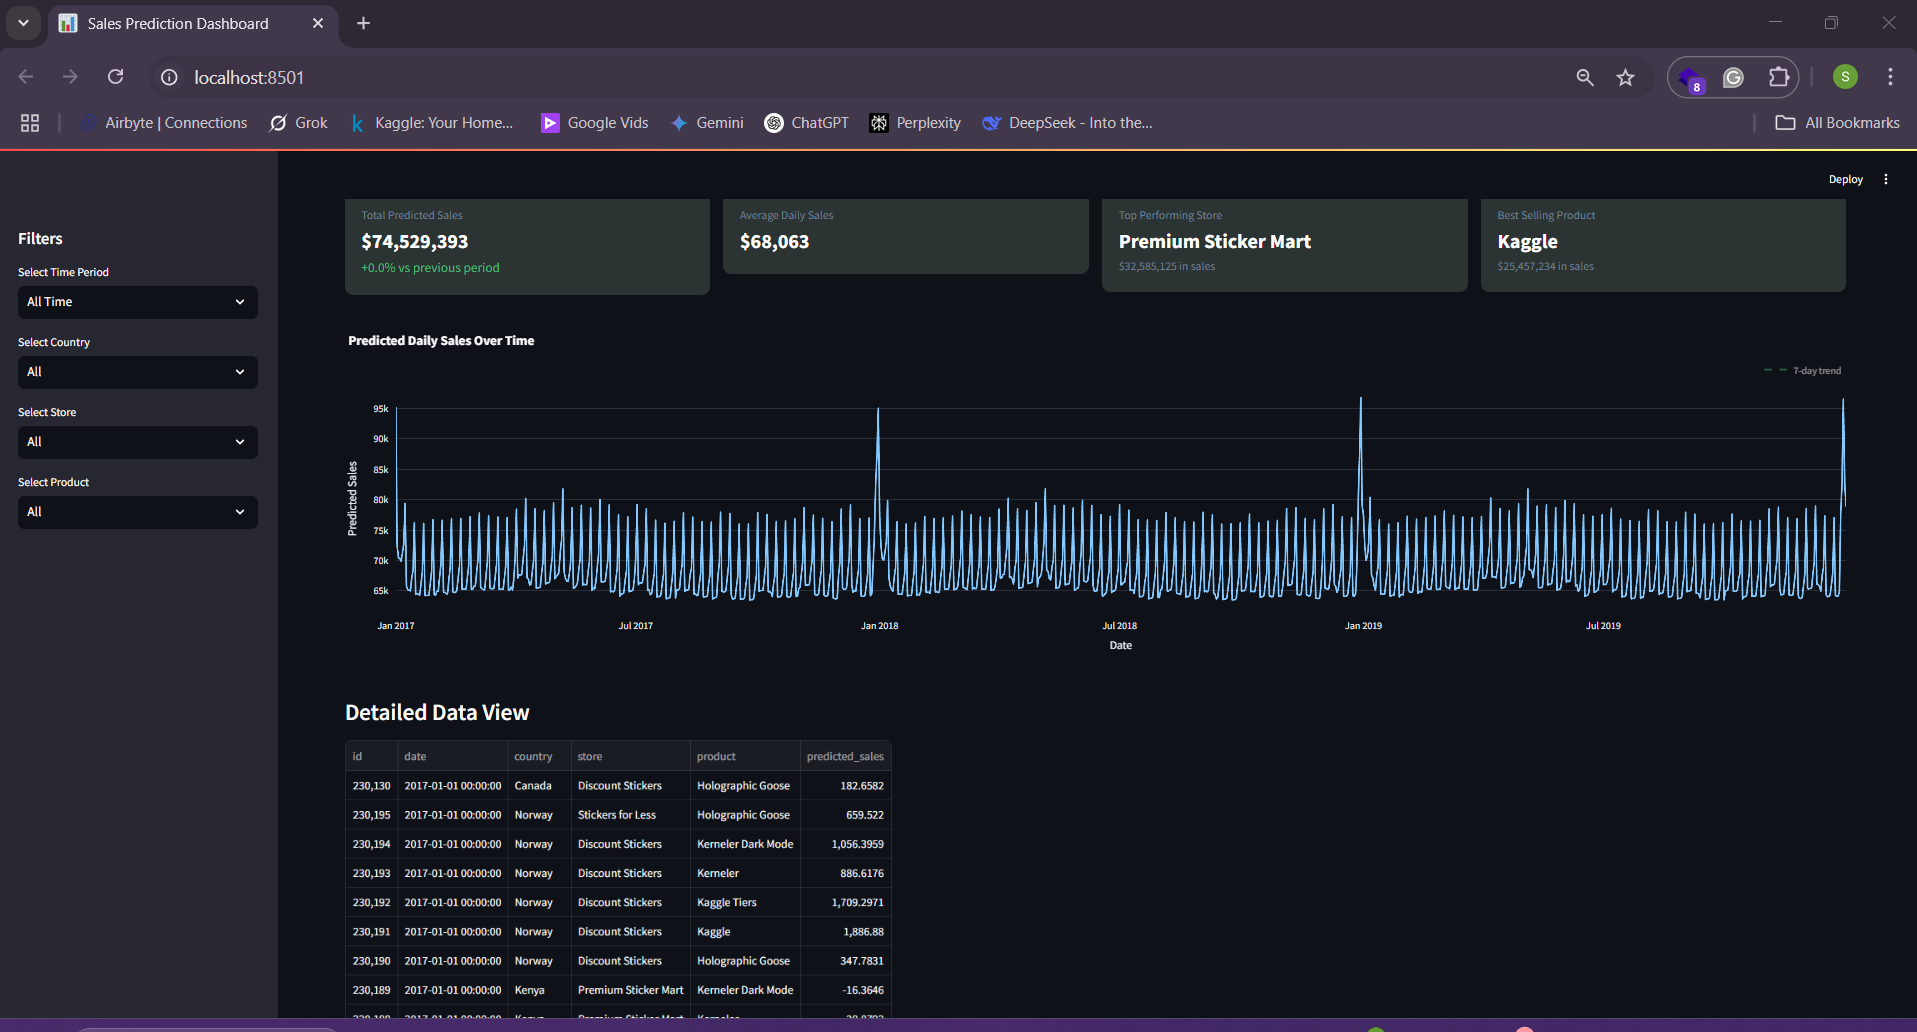

## Running the Entire Pipeline

Here's how to run the entire pipeline:

1. Upload data to Modal:
```bash
python data_upload.py data/
```

2. Train the model on Modal:
```bash
python train.py
```

3. Deploy the API on Modal:
```bash
python serve.py
```

4. Run the Streamlit dashboard:
```bash
cd ui
streamlit run streamlit_ui.py
```

## Key Benefits of This Approach

1. **Serverless Training and Deployment**: Modal handles all infrastructure, scaling, and container management.

2. **Production-Ready API**: The API is automatically served with proper endpoints, error handling, and authentication.

3. **Separation of Concerns**: Data preprocessing, model training, and serving are cleanly separated.

4. **Interactive Dashboard**: Stakeholders can visualize predictions without technical knowledge.

5. **Reproducibility**: The entire pipeline is defined in code, making it easy to reproduce.

## Improvements

Adding feature store - I shall be adding a feature store in v2 of this blog. This will help with Consistent feature engineering and avoid duplicating the same processing logic in different scripts etc.

## Conclusion

In this notebook, we've built an end-to-end machine learning system for forecasting sticker sales. We've used FastAI for preprocessing, model building, Modal to run our training job, deploy and serve our model, and Streamlit for visualization.

This approach demonstrates how modern tools can simplify the MLOps process, reducing the overhead involved in deploying machine learning solutions to production.